# Compare PEA software test set to matched flight data

Ref: https://chandramission.slack.com/archives/C01D83RUG0L/p1724092824832339

This provides information on the sampling and comparison of acquisition failure
statistics to flight data a simulated data set from the software ACA test set (SWATS).

The data in this notebook consist of most OR acquisitions (obsid < 38000) in 2022 and
2023. The flight data are filtered to remove acquisitions that failed OBC ID due to
the IR or SP flag being set, then matched by ObsID and slot to the SWATS data.

## Summary

There is generally good agreement between the simulated acquisition statistics and
flight. However, in some bins there is disagreement that is statistically significant.
These are not fully understood, but the outliers are isolated and associated with
low-number statistics.

There is an overall bias that SWATS fails acquisition about 1% less than comparable
flight acquisitions. The source of this discrepancy is open for discussion, but it seems
credible that the flight hardware in a harsh space environment might fail acquisition
due to unmodeled effects.

In [1]:
import itertools
import sys
import warnings

sys.path.insert(0, "/Users/aldcroft/git/chandra_aca")

import matplotlib.pyplot as plt
import matplotlib.style
import numpy as np
from astropy.table import Table
from chandra_aca import star_probs
from cxotime import CxoTime

from utils_stats import (
    AcqBins,
    ValsBins,
    flatten_pea_test_data,
    get_acq_stats_data,
    get_samples_fails,
    pformat_sampling,
    plot_diff_pmf,
    read_twiki_csv,
)

matplotlib.style.use("bmh")
%matplotlib inline

In [2]:
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [3]:
# Original sampling for ASVT data for reference
# mag_vals = (8.0, 9.0, 9.5, 9.75, 10.0, 10.25, 10.5, 10.75)
# t_ccd_vals = (-15, -13, -11, -9, -8, -7, -6, -5, -4, -3, -2, 0, 2)

mag_vals = (9, 9.5, 10, 10.5)
t_ccd_vals = (-13, -11, -9, -7, -5, -4)
hw_vals = (60, 80, 100, 120, 140, 160)

acq_bins = AcqBins(mag=ValsBins(mag_vals), t_ccd=ValsBins(t_ccd_vals))

### Get flight data

In [4]:
flt_all = get_acq_stats_data("2022:001", "2024:001")
flt_all.info

<Table length=32904>
     name       dtype 
-------------- -------
        tstart float64
         obsid   int64
        obc_id    bool
     halfwidth   int64
       mag_aca float32
       mag_obs float64
         color float32
      img_func  bytes7
       ion_rad    bool
       sat_pix    bool
      agasc_id   int64
         t_ccd float64
          slot   int64
      star_mag float32
search_success    bool
 search_box_hw   int64
      ccd_temp float64
         ObsID   int64
     mag_catid    bool
          year float32
       quarter float32

### Get SWATS data

In [5]:
# Large dataset with flight-like sampling but expanded temperatures
# fn = "PEA_SW_TS_Acq_results_2024_08_27_w_more flight_like_maxmag.csv"
# Flight-like sampling
fn = "PEA_SW_TS_Acq_results_2024_09_19_flight_recreation.csv"
swats8 = Table.read(fn, format="ascii.csv")
swats = flatten_pea_test_data(swats8)
swats.rename_column("Mag_sim_info", "star_mag")
swats.rename_column("Time_for_Proper_Motion", "tstart")
# Some bright stars around 1.0 mag
swats = swats[swats["star_mag"] > 4.0]
swats = swats[
    "ccd_temp", "star_mag", "search_box_hw", "search_success", "slot", "ObsID", "tstart"
]
swats.info

<Table length=22999>
     name       dtype 
-------------- -------
      ccd_temp float64
      star_mag float64
 search_box_hw   int64
search_success    bool
          slot   int64
         ObsID   int64
        tstart   str21

In [6]:
def get_model_p_fail(dat):
    p_succ = star_probs.acq_success_prob(
        date=dat["tstart"],
        mag=dat["star_mag"],
        t_ccd=dat["ccd_temp"],
        halfwidth=dat["search_box_hw"],
    )
    return 1 - p_succ

In [7]:
flt_all["p_fail"] = get_model_p_fail(flt_all)
swats["p_fail"] = get_model_p_fail(swats)


### Summary of sampling

This is the number of acquisition samples in each bin.

In [8]:
def match_datasets(dat1, dat2):
    """Match datasets by ObsID and slot"""
    keys1 = [f"{row['ObsID']}_{row['slot']}" for row in dat1]
    keys2 = [f"{row['ObsID']}_{row['slot']}" for row in dat2]
    keys12 = list(set(keys1) & set(keys2))
    ok1 = np.in1d(keys1, keys12)
    ok2 = np.in1d(keys2, keys12)
    dat1 = dat1[ok1]
    dat2 = dat2[ok2]
    dat1.sort(["ObsID", "slot"])
    dat2.sort(["ObsID", "slot"])
    assert np.all(dat1["ObsID"] == dat2["ObsID"])
    assert np.all(dat1["slot"] == dat2["slot"])
    assert np.all(dat1["search_box_hw"] == dat2["search_box_hw"])
    return dat1, dat2

Before matching 32904 22999
After matching 20273 20273


Text(0.5, 0, 'Delta ccd_temp (C)')

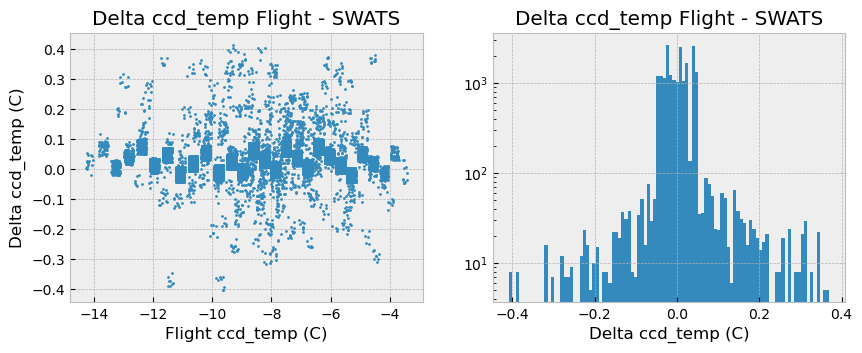

In [9]:
# Match datasets by ObsID and slot.
print("Before matching", len(flt_all), len(swats))
flt_all, swats = match_datasets(flt_all, swats)
print("After matching", len(flt_all), len(swats))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.5))
rx = np.random.uniform(0, 0.3, size=len(flt_all))
ry = np.random.uniform(0, 0.05, size=len(flt_all))
ax1.plot(
    flt_all["ccd_temp"] + rx,
    flt_all["ccd_temp"] - swats["ccd_temp"] + ry,
    ".",
    ms=2.0,
)
ax1.set_title("Delta ccd_temp Flight - SWATS")
ax1.set_xlabel("Flight ccd_temp (C)")
ax1.set_ylabel("Delta ccd_temp (C)")
ax2.hist(flt_all["ccd_temp"] - swats["ccd_temp"], bins=100, log=True)
ax2.set_title("Delta ccd_temp Flight - SWATS")
ax2.set_xlabel("Delta ccd_temp (C)")

In [10]:
CxoTime(np.min(flt_all["tstart"])).date, CxoTime(np.max(flt_all["tstart"])).date

('2022:001:17:34:53.125', '2023:365:15:14:47.921')

### Define simulated dataset the SWATS data

This notebook could be run with other data sets combined, e.g. ASVT data.

In [11]:
sim_all = swats

### Overview of coverage in CCD temperature, magnitude, and halfwidth for SWATS data

In [12]:
flt_lines = pformat_sampling(flt_all, acq_bins, add_mag=True)
# asvt_lines = pformat_sampling(asvt, acq_bins, add_mag=False)
swats_lines = pformat_sampling(swats, acq_bins, add_mag=False)
_summary = Table([flt_lines, swats_lines], names=["Flight", "SWATS"])
_summary.pprint_all()

               Flight                               SWATS               
------------------------------------ -----------------------------------
                       Halfwidth 60:                       Halfwidth 60:
mag  -13.0 -11.0 -9.0 -7.0 -5.0 -4.0  |  -13.0 -11.0 -9.0 -7.0 -5.0 -4.0
---- ----- ----- ---- ---- ---- ---- --- ----- ----- ---- ---- ---- ----
   9     2    51  170  146   23    0   |     2    51  137  178   23    0
 9.5    23    66   78   99   59    4   |    23    66   62  114   60    4
  10    12    65  144  174   83    8   |     6    51  122  193   83    8
10.5    23   102   77   55   10    2   |    29   116   69   67   10    2
                                                                        
                       Halfwidth 80:                       Halfwidth 80:
mag  -13.0 -11.0 -9.0 -7.0 -5.0 -4.0  |  -13.0 -11.0 -9.0 -7.0 -5.0 -4.0
---- ----- ----- ---- ---- ---- ---- --- ----- ----- ---- ---- ---- ----
   9    17    43   45   18   12    2   |    17    4

Text(0.5, 0, 'CCD Temperature (C)')

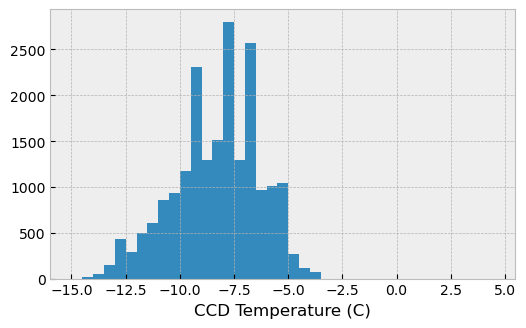

In [13]:
plt.figure(figsize=(6, 3.5))
plt.hist(swats["ccd_temp"], bins=np.arange(-15, 5, 0.5))
plt.xlabel("CCD Temperature (C)")

Text(0, 0.5, 'Star Magnitude')

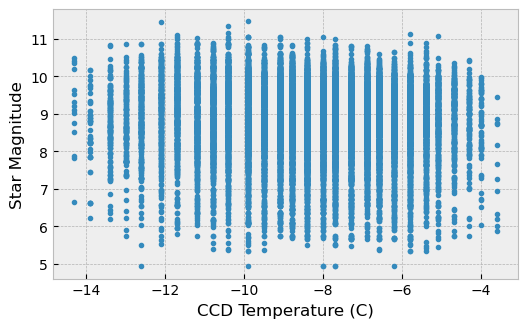

In [14]:
plt.figure(figsize=(6, 3.5))
plt.plot(swats["ccd_temp"], swats["star_mag"], ".")
plt.xlabel("CCD Temperature (C)")
plt.ylabel("Star Magnitude")

Text(0.5, 0, 'Search Box Half-Width')

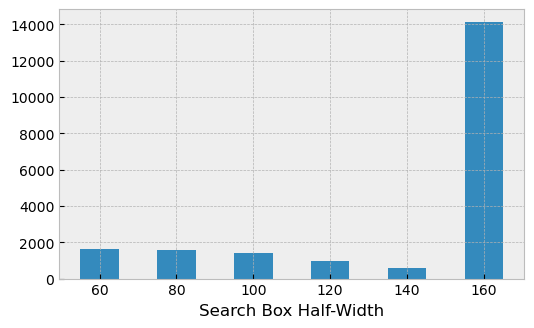

In [15]:
plt.figure(figsize=(6, 3.5))
plt.hist(swats["search_box_hw"], bins=np.arange(55, 175, 10))
plt.xlabel("Search Box Half-Width")

### Get the number of acquisition samples and successes in the defined bins

In [16]:
def get_sample_mask(n_samp_flt, n_samp_sim, n_fail_flt, n_fail_sim, min_fail_rate=0.05):
    """Get a mask for bins that have enough samples and a high enough failure rate.

    Each of the inputs is a 3D array (mag, t_ccd, hw) with binned values. This function
    returns a similarly-shaped boolean array that is True where the failure rate is high
    and the number of samples is high enough.
    """
    ok = (
        (n_samp_flt >= 30)
        & (n_samp_sim >= 30)
        & (
            (n_fail_flt / n_samp_flt.clip(1) > min_fail_rate)
            | (n_fail_sim / n_samp_sim.clip(1) > min_fail_rate)
        )
    )
    return ok

### Functions for fitting a line to data with errors in both X and Y

In [17]:
from scipy.odr import ODR, Model, RealData


def linear_func(beta, x):
    return beta[0] * x + beta[1]


def fit_linear_model(xs, ys, xerrs, yerrs):
    # Perform a linear fit for data with error bars in both x and y using Orthogonal
    # Distance Regression (ODR).

    linear_model = Model(linear_func)
    data = RealData(xs, ys, sx=xerrs, sy=yerrs)
    odr = ODR(data, linear_model, beta0=[1.0, 0.0])
    output = odr.run()
    return output.beta  # beta[0] is the slope, beta[1] is the intercept


In [18]:
def plot_flt_all_vs_sim_all(
    flt,
    sim,
    acq_bins,
    sum_over_hw=False,
    force_fail_prob=None,
    print_stats=False,
):
    n_samp_sim, n_fail_sim = get_samples_fails(
        sim,
        acq_bins,
        force_fail_prob=force_fail_prob,
    )
    n_samp_flt, n_fail_flt = get_samples_fails(flt, acq_bins)

    if sum_over_hw:
        # sum over search box half-width (axis 2)
        n_samp_flt = np.sum(n_samp_flt, axis=2)
        n_samp_sim = np.sum(n_samp_sim, axis=2)
        n_fail_flt = np.sum(n_fail_flt, axis=2)
        n_fail_sim = np.sum(n_fail_sim, axis=2)

    sample_mask = get_sample_mask(
        n_samp_flt, n_samp_sim, n_fail_flt, n_fail_sim, min_fail_rate=0.02
    )
    sample_mask.shape
    xs = []
    ys = []
    xerrs = []
    yerrs = []
    for indices in itertools.product(*[range(n_ax) for n_ax in sample_mask.shape]):
        if not sample_mask[indices]:
            continue
        k1 = n_fail_flt[indices]
        n1 = n_samp_flt[indices]
        k2 = n_fail_sim[indices]
        n2 = n_samp_sim[indices]
        pf1, pf1_lo, pf1_hi = star_probs.binomial_confidence_interval(k1, n1)
        pf2, pf2_lo, pf2_hi = star_probs.binomial_confidence_interval(k2, n2)

        xs.append(pf1)
        ys.append(pf2)
        xerrs.append(max(pf1_hi - pf1_lo, 0.05) / 2)
        yerrs.append(max(pf2_hi - pf2_lo, 0.05) / 2)

        # Plot pf1 vs pf2 with error bars from binomial confidence intervals
        plt.errorbar(
            pf1,
            pf2,
            xerr=[[pf1 - pf1_lo], [pf1_hi - pf1]],
            yerr=[[pf2 - pf2_lo], [pf2_hi - pf2]],
            fmt="o",
            color="C0",
            lw=1,
            ms=4,
        )
        if sum_over_hw and abs(pf1 - pf2) > 0.1:
            plt.text(
                pf1 + 0.01,
                pf2 + 0.01,
                f"{mag_vals[indices[0]]}, {t_ccd_vals[indices[1]]}",
                fontsize=8,
            )
        if print_stats:
            print(
                f"Mag={mag_vals[indices[0]]:4.1f} T_ccd={t_ccd_vals[indices[1]]:4d}",
                end=" ",
            )
            print(
                f"FLT: {k1:3d}/{n1:4d} = {pf1:.3f} ({pf1_lo:.3f}, {pf1_hi:.3f})",
                end=" ",
            )
            print(
                f"SWATS: {k2:3d}/{n2:4d} = {pf2:.3f} ({pf2_lo:.3f}, {pf2_hi:.3f})",
                end="",
            )
            print(" **" if abs(pf1 - pf2) > 0.1 else "")

    plt.plot([0, 0.5], [0, 0.5], "k--", lw=1, label="Identity line")
    plt.xlabel("Flight Failure Probability")
    plt.ylabel("SWATS Failure Probability")

    # Generate points for the fitted line
    r_fit = fit_linear_model(xs, ys, xerrs, yerrs)
    x_fit = np.array([0, 0.5])
    y_fit = linear_func(r_fit, x_fit)
    plt.plot(x_fit, y_fit, label="Fitted line", color="C1")
    plt.legend(loc="best")


Mag= 9.0 T_ccd= -11 FLT:  17/ 579 = 0.029 (0.023, 0.037) SWATS:   4/ 577 = 0.007 (0.004, 0.011)
Mag= 9.0 T_ccd=  -9 FLT:  47/1547 = 0.030 (0.026, 0.035) SWATS:  26/1302 = 0.020 (0.016, 0.024)
Mag= 9.0 T_ccd=  -7 FLT:  58/1381 = 0.042 (0.037, 0.048) SWATS:  47/1632 = 0.029 (0.025, 0.033)
Mag= 9.0 T_ccd=  -5 FLT:  33/ 537 = 0.061 (0.052, 0.073) SWATS:  18/ 531 = 0.034 (0.027, 0.043)
Mag= 9.0 T_ccd=  -4 FLT:   3/  34 = 0.088 (0.051, 0.149) SWATS:   2/  36 = 0.056 (0.029, 0.107)
Mag= 9.5 T_ccd= -13 FLT:   6/ 182 = 0.033 (0.022, 0.049) SWATS:   5/ 185 = 0.027 (0.018, 0.042)
Mag= 9.5 T_ccd= -11 FLT:  28/ 571 = 0.049 (0.041, 0.059) SWATS:  20/ 559 = 0.036 (0.029, 0.044)
Mag= 9.5 T_ccd=  -9 FLT: 122/1550 = 0.079 (0.072, 0.086) SWATS:  79/1268 = 0.062 (0.056, 0.069)
Mag= 9.5 T_ccd=  -7 FLT: 173/1369 = 0.126 (0.118, 0.136) SWATS: 170/1676 = 0.101 (0.094, 0.109)
Mag= 9.5 T_ccd=  -5 FLT:  81/ 543 = 0.149 (0.135, 0.165) SWATS:  83/ 536 = 0.155 (0.140, 0.171)
Mag= 9.5 T_ccd=  -4 FLT:  12/  37 = 0.32

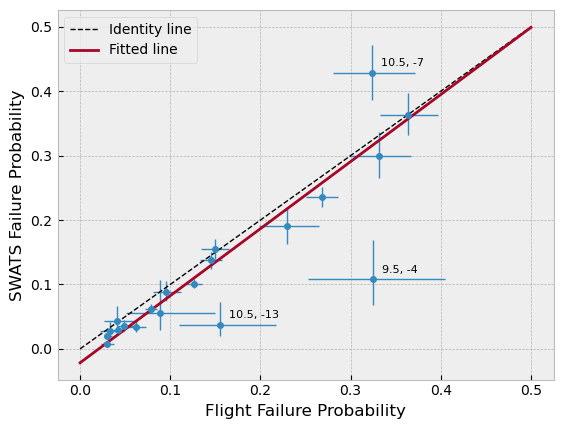

In [19]:
plot_flt_all_vs_sim_all(flt_all, sim_all, acq_bins, sum_over_hw=True, print_stats=True)

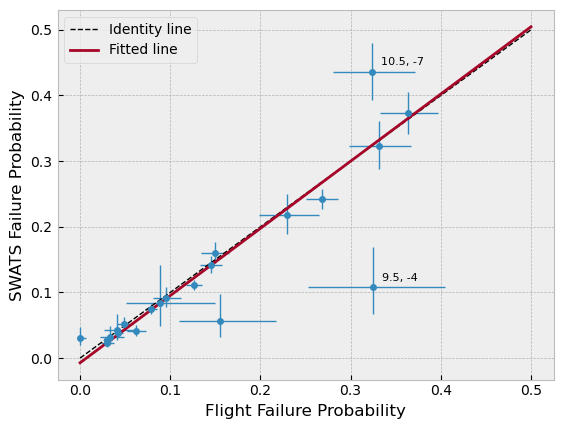

In [20]:
plot_flt_all_vs_sim_all(
    flt_all, sim_all, acq_bins, sum_over_hw=True, force_fail_prob=0.01
)

## Compute CDF of difference between flight and PEA test set data

In [21]:
def plot_acq_failure_prob_distributions(flt, sim, halfwidth=None, force_fail_prob=None):
    print(f"Acq Failure Probability Distributions (halfwidth={halfwidth})")

    n_samp_sim_all, n_fail_sim_all = get_samples_fails(
        sim,
        acq_bins,
        force_fail_prob=force_fail_prob,
    )
    n_samp_flt_all, n_fail_flt_all = get_samples_fails(flt, acq_bins)

    if halfwidth is not None:
        kk = list(acq_bins.halfwidth.vals).index(halfwidth)
        n_samp_flt = n_samp_flt_all[:, :, kk]
        n_samp_sim = n_samp_sim_all[:, :, kk]
        n_fail_flt = n_fail_flt_all[:, :, kk]
        n_fail_sim = n_fail_sim_all[:, :, kk]
    else:
        n_samp_flt = np.sum(n_samp_flt_all, axis=2)
        n_samp_sim = np.sum(n_samp_sim_all, axis=2)
        n_fail_flt = np.sum(n_fail_flt_all, axis=2)
        n_fail_sim = np.sum(n_fail_sim_all, axis=2)

    ni, nj = n_samp_flt.shape
    sample_mask = get_sample_mask(n_samp_flt, n_samp_sim, n_fail_flt, n_fail_sim)

    # Truncate up to the nearest multiple of 2.
    n_row = int(np.ceil(np.count_nonzero(sample_mask) / 2))
    fig, axes = plt.subplots(n_row, 4, figsize=(12, 2.75 * n_row))

    i_plot = 0
    for ii in range(0, ni):
        for jj in range(nj):
            if not sample_mask[ii, jj]:
                continue

            k1 = n_fail_flt[ii, jj]
            n1 = n_samp_flt[ii, jj]
            k2 = n_fail_sim[ii, jj]
            n2 = n_samp_sim[ii, jj]

            title = f"mag={mag_vals[ii]} T_ccd={t_ccd_vals[jj]}"
            plot_diff_pmf(
                k1,
                n1,
                k2,
                n2,
                title,
                "Flight",
                "Sim",
                axes=axes.flat[i_plot : i_plot + 2],
            )
            i_plot += 2

    fig.tight_layout()


Acq Failure Probability Distributions (halfwidth=None)


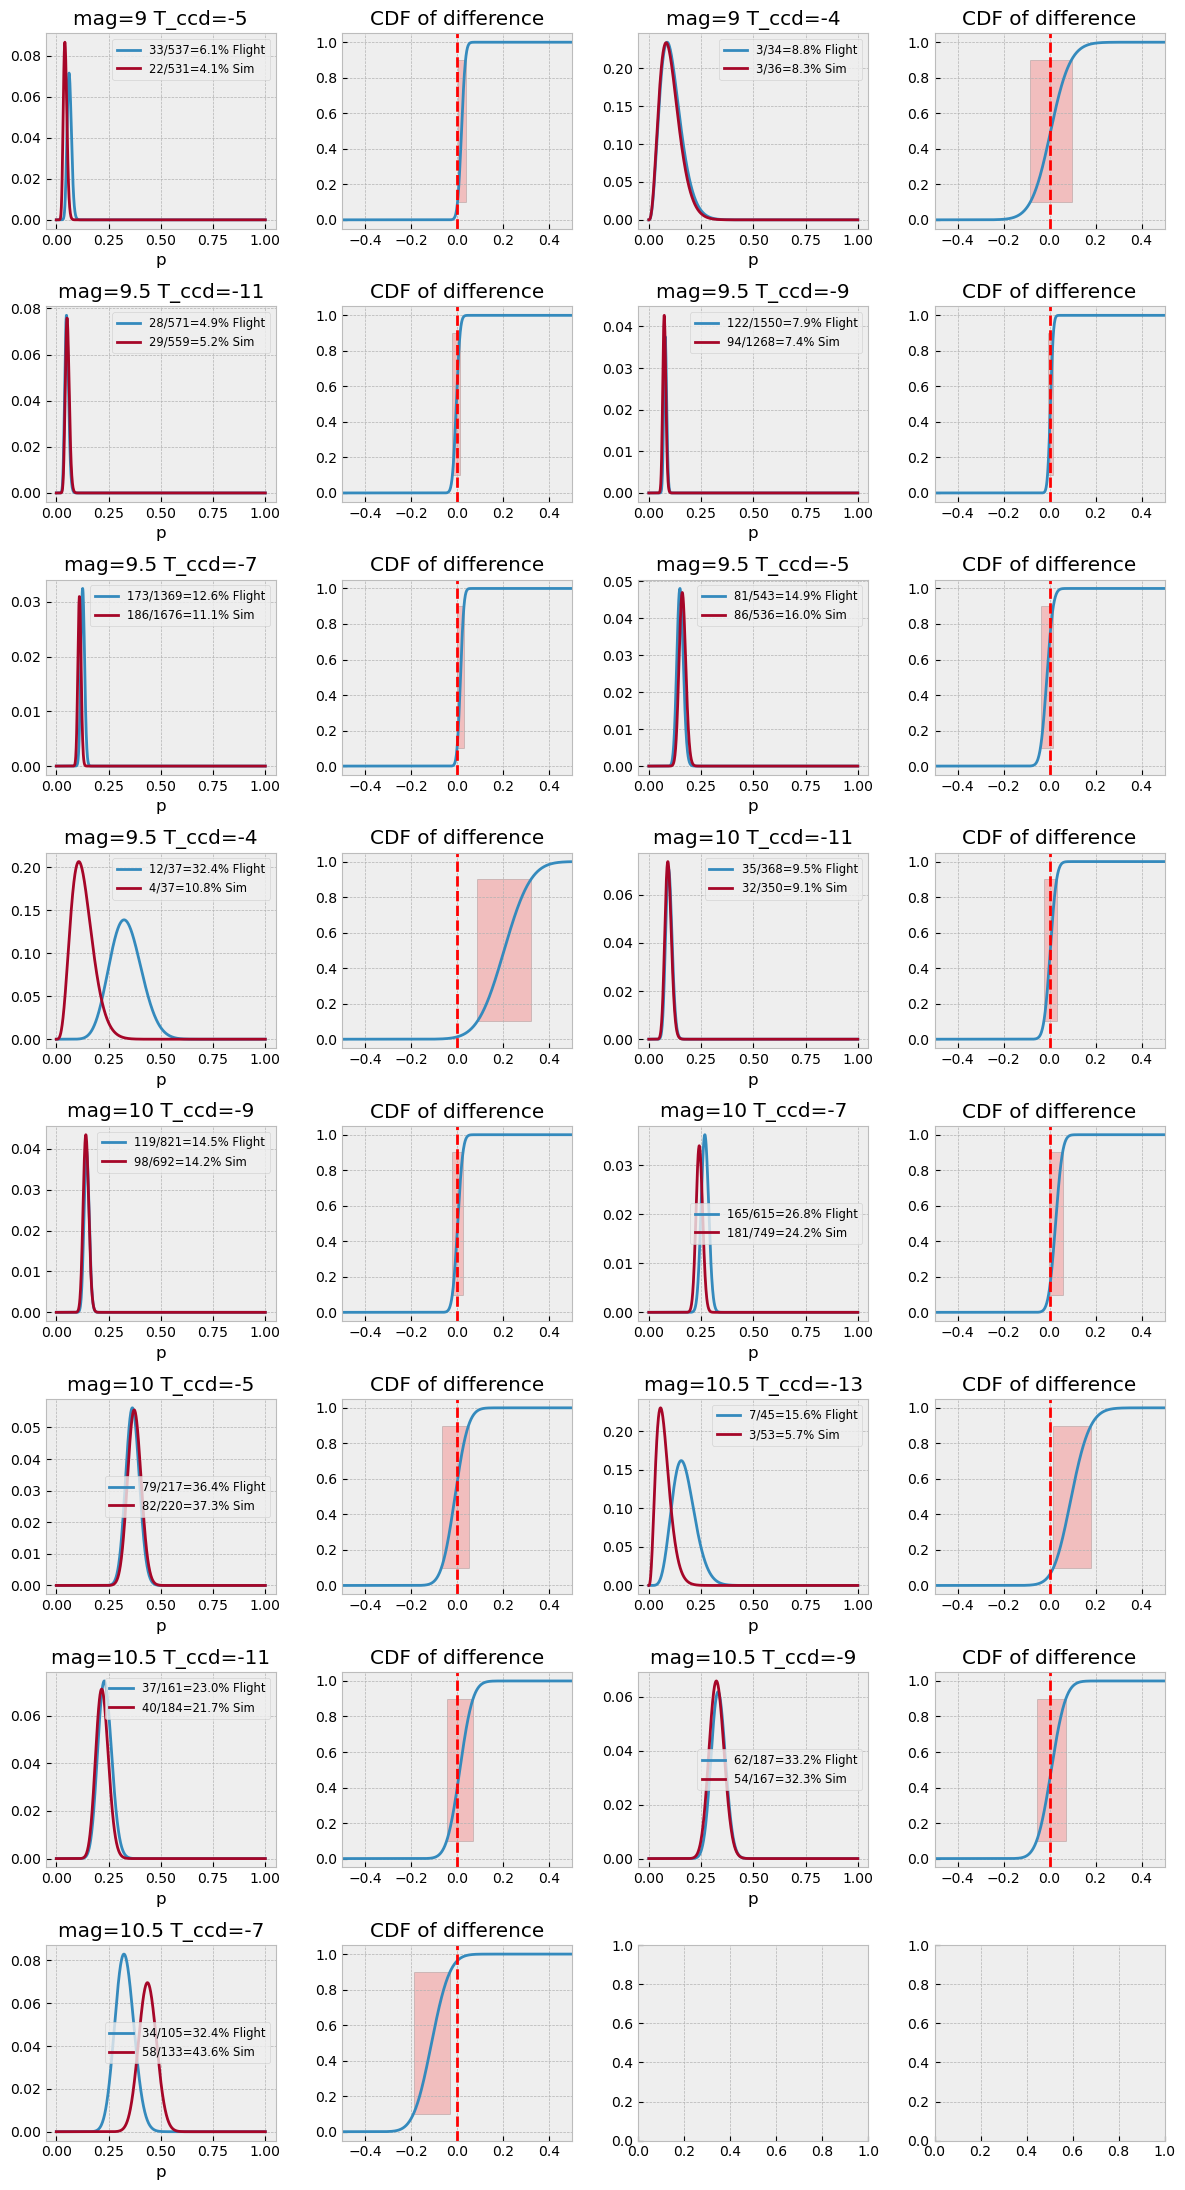

In [22]:
plot_acq_failure_prob_distributions(
    flt_all, sim_all, halfwidth=None, force_fail_prob=0.01
)

In [23]:
if False:
    for hw in acq_bins.halfwidth.vals:
        plot_acq_failure_prob_distributions(hw)

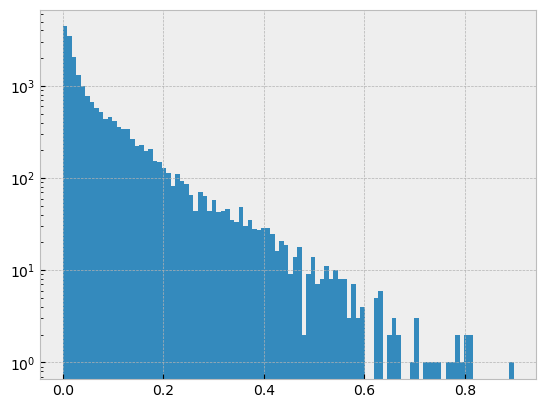

In [24]:
plt.hist(flt_all["p_fail"], bins=100, log=True);

### Simple comparison of Flight vs SWATS acq failure probability

Select only stars where the model-predicted probabilty of failure is > 0.1. This removes
the large population of bright / low-temp acquisitions that have very low failure rates.

In [25]:
ok = flt_all["p_fail"] > 0.1
k1, n1 = np.count_nonzero(~flt_all["search_success"][ok]), np.count_nonzero(ok)
k2, n2 = np.count_nonzero(~swats["search_success"][ok]), np.count_nonzero(ok)
p1, p1_lo, p1_hi = star_probs.binomial_confidence_interval(k1, n1)
p2, p2_lo, p2_hi = star_probs.binomial_confidence_interval(k2, n2)
print(f"Flight: k={k1} n={n1} p={k1/n1:.4f} ({p1_lo:.4f} : {p1_hi:.4f})")
print(f"SWATS:  k={k2} n={n2} p={k2/n2:.4f} ({p2_lo:.4f} : {p2_hi:.4f})")
print(f"{p1 - p2:.4f}")

Flight: k=887 n=4468 p=0.1985 (0.1926 : 0.2046)
SWATS:  k=839 n=4468 p=0.1878 (0.1820 : 0.1937)
0.0107
